In [1]:
# Setup the environment first

# read: https://github.com/mirnylab/cooler/issues/138 for more details:

# !export MKL_NUM_THREADS=1 - # not working in a notebook ((
# instead do this, after making sure mkl is installed
import mkl
mkl.set_num_threads(1)

In [14]:
# neccessary modules to be imported

import os.path as op
from scipy.stats import poisson
import pandas as pd
import numpy as np
import cooler

from cooltools import dotfinder

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

from cooltools.lib import numutils

In [3]:

# keeping some of the relevant CLI commands here
# useful for preprocessing cooler files - before calling dots

# 1. re-balancing - cis-only is worth checking out at the very least ...
# cooler balance -p {threads} --ignore-diags 1 --force --name 'wsnake' {input}::/resolutions/{res}

# 2. calculation of expected
# cooltools compute-expected -p {threads} --weight-name 'wsnake' --drop-diags 1 {input[0]}::/resolutions/{res}

# in this example chromosomes 4 and 8  and also 2 and 20 undergo arm-level rearrangements ...

In [4]:
mut = cooler.Cooler("/home/venevs/Downloads/Sample11_4p-8q_2p-20q.1Mb.cool")
ctr = cooler.Cooler("/home/venevs/Downloads/Ctrl_1Mb.cool")

In [ ]:
!cooler balance -p 6 --ignore-diags 2 --force /home/venevs/Downloads/Sample11_4p-8q_2p-20q.1Mb.cool
!cooler balance -p 6 --ignore-diags 2 --force /home/venevs/Downloads/Ctrl_1Mb.cool

In [50]:
balanced = True


In [51]:
c1 = ctr.matrix(balance=balanced).fetch("2")
c2 = ctr.matrix(balance=balanced).fetch("20")
c12 = ctr.matrix(balance=balanced).fetch("2","20")

c1_width = c1.shape[1]
c2_width = c2.shape[1]

c1_height = c1.shape[0]
c2_height = c2.shape[0]


width = c1_width+c2_width
height = c1_height+c2_height

cmonster = np.zeros((height,width))

In [52]:
coe1 = get_OE(c1)
coe2 = get_OE(c2)

coe12 = c12/np.nanmean(c12)

cmonster[:c1_width,:c1_height] = coe1
cmonster[c1_width:,c1_height:] = coe2
cmonster[:c1_width,c1_height:] = coe12
cmonster[c1_height:,:c1_height] = coe12.transpose()

In [53]:
m1 = mut.matrix(balance=balanced).fetch("2")
m2 = mut.matrix(balance=balanced).fetch("20")
m12 = mut.matrix(balance=balanced).fetch("2","20")
print(m1.shape)
print(m2.shape)
print(m12.shape)

m1_width = m1.shape[1]
m2_width = m2.shape[1]

m1_height = m1.shape[0]
m2_height = m2.shape[0]


width = m1_width+m2_width
height = m1_height+m2_height

monster = np.zeros((height,width))


(244, 244)
(64, 64)
(244, 64)


/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


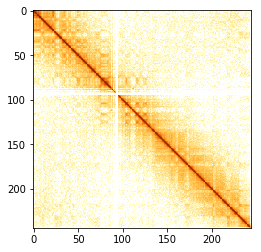

In [39]:
plt.imshow(np.log(m1),cmap='YlOrBr')

/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


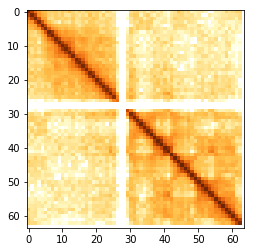

In [40]:
plt.imshow(np.log(m2),cmap='YlOrBr')

In [41]:
def get_OE(A,ignore_diags=2):
    A = np.array(A)
    A[~np.isfinite(A)] = 0
    mask = A.sum(axis=0) > 0

    if A.shape[0] <= ignore_diags + 3 or mask.sum() <= ignore_diags+3:
        return (
            np.array([np.nan for i in range(n_eigs)]),
            np.array([np.ones(A.shape[0]) * np.nan for i in range(n_eigs)]),
        )
    if ignore_diags:
        for d in range(-ignore_diags + 1, ignore_diags):
            numutils.set_diag(A, 1.0, d)

    OE, _, _, _ = numutils.observed_over_expected(A, mask)
    # ...
    return OE

In [61]:

oe1 = get_OE(m1)
oe2 = get_OE(m2)

oe12 = m12/np.nanmean(m12)
# oe12 = m12/np.nanmean(m12)


monster[:m1_width,:m1_height] = oe1
monster[m1_width:,m1_height:] = oe2
monster[:m1_width,m1_height:] = oe12
monster[m1_height:,:m1_height] = oe12.transpose()


/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


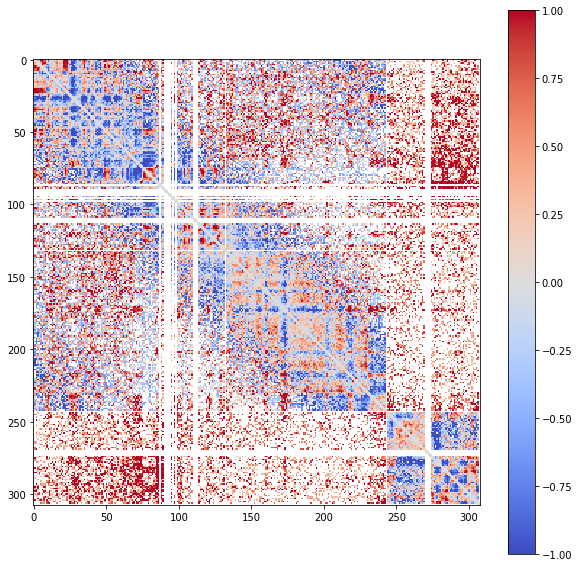

In [64]:
# ,cmap="YlOrBr",vmin=-9,vmax=-1
plt.imshow(np.log(monster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


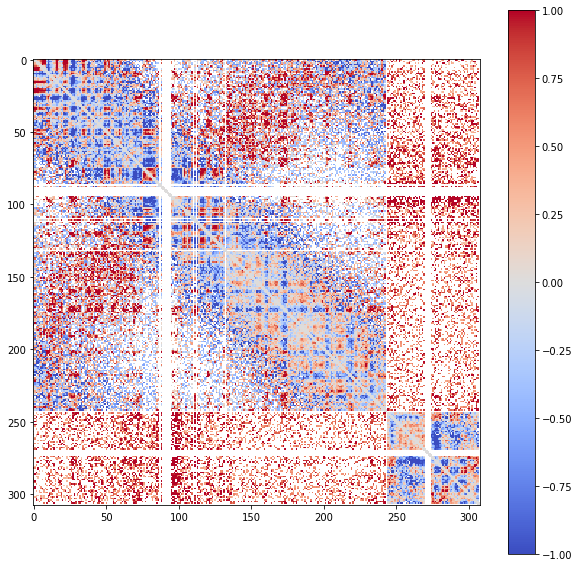

In [60]:
plt.imshow(np.log(cmonster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


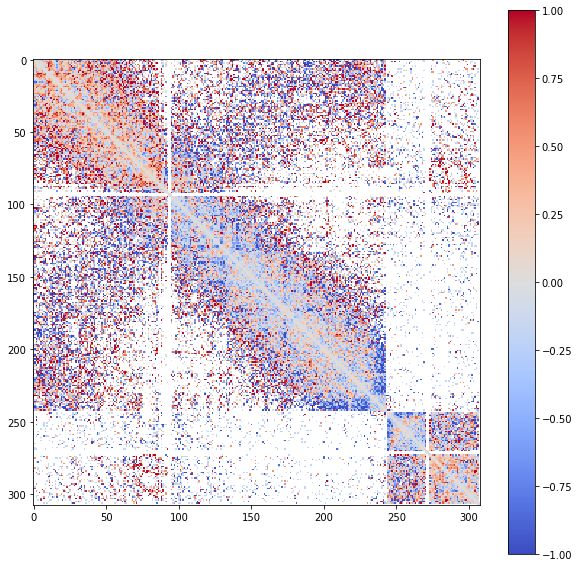

In [45]:
plt.imshow(np.log(monster)-np.log(cmonster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

In [ ]:
plt.imshow(np.log(cmonster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()

In [ ]:
plt.imshow(np.log(monster),cmap='coolwarm',vmin=-1,vmax=1)#,vmin=0,vmax=3)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.colorbar()